In [1]:
import cv2
import os
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from ast import literal_eval

## Redimension de Imagenes +  Escalado de Pixeles

In [118]:
root_imagenes = 'imagenes/furgones'
root_imagenes_mnist = 'imagenes/furgones_mnist/'

In [119]:
def preprocesar_imagen(ruta_imagen):
    for path, subdirs, files in os.walk(ruta_imagen):
        name = ""
        for name in files:
            try:
                img_path = os.path.join(path,name)
                img = cv2.imread(img_path)
                img = resize_image(root_imagenes + name,img)
                flip_image(root_imagenes_mnist + "_flip_" + name,img)
                
                
            except Exception as e:
                print(e)
                print(name)

In [15]:
preprocesar_imagen(root_imagenes)

In [120]:
def resize_image(path,img):
    resize_img=cv2.resize(img, (28,28))
    cv2.imwrite(path,resize_img)  
    return resize_img
    

In [7]:
def flip_image(path,img):
    flip_img=cv2.flip(img,1)
    cv2.imwrite(path,flip_img)  

In [32]:
rutas_images_mnist = [
    'imagenes/autos_mnist/',
    'imagenes/camionetas_mnist/',
    'imagenes/furgones_mnist/',
    'imagenes/motos_mnist/'
]

In [49]:
# Para cada categoria, hacemos el siguiente procedimiento: X=imagen, y=numero de categoria.
labels = ['Autoelevador', 'Auto', 'Buggy', 'Camioneta', 'Camion', 'Colectivo',
         'Cuatriciclo', 'Furgon', 'Moto', 'Pala Cargadora']

In [50]:
def crear_dataframe():
    arreglo = []
    df = pd.DataFrame()
    for ruta_imagen in rutas_images_mnist:
        print(ruta_imagen)
        for path, subdirs, files in os.walk(ruta_imagen):
            name = ""
            for name in files:
                try:
                    # Abro la imagen
                    img_path = os.path.join(path,name)
                    img = cv2.imread(img_path)
                    
                    # PASO A ESCALA DE GRISES --> este me deja una sola dimension de RGB
                    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
                    
                    # Normalización DE PIXELES, DIVIDO CADA PIXEL POR 255,
                    img = img / 255 

                    # aca me quedo con un solo canal del RGB
                    array_img = img.ravel() 
                    
                    numero_categoria = get_numero_categoria(ruta_imagen)
                    
                    array_img = np.insert(array_img,len(array_img), numero_categoria)
                    arreglo.append(array_img) 
                    
                except Exception as e:
                    print(e)
                    #print(name)


        df = pd.DataFrame(arreglo)
        #print(df)
    return df
# Duda:en ningun momento del for vacio el arreglo[]
# No serian solamente dos columnas.

In [48]:
def get_numero_categoria(categoria):
    if("elevador" in categoria):
        return 0
    elif("auto" in categoria):
        return 1
    elif("camioneta" in categoria):
        return 2
    elif("camion" in categoria):
        return 3
    elif("colectivo" in categoria):
        return 4
    elif("cuatriciclo" in categoria):
        return 5
    elif("furgon" in categoria):
        return 6
    elif("moto" in categoria):
        return 7
    elif("pala" in categoria):
        return 8
    else:
        return 0

In [51]:
df = crear_dataframe()

imagenes/autos_mnist/
imagenes/camionetas_mnist/
imagenes/furgones_mnist/
imagenes/motos_mnist/


In [52]:
print(df)

           0         1         2         3         4         5         6    \
0     0.721569  0.733333  0.686275  0.670588  0.686275  0.631373  0.670588   
1     0.650980  0.627451  0.647059  0.643137  0.650980  0.650980  0.733333   
2     0.294118  0.674510  0.631373  0.603922  0.580392  0.521569  0.564706   
3     0.462745  0.596078  0.545098  0.505882  0.498039  0.466667  0.529412   
4     0.392157  0.388235  0.364706  0.352941  0.254902  0.282353  0.337255   
5     0.639216  0.541176  0.572549  0.654902  0.450980  0.576471  0.556863   
6     0.752941  0.780392  0.874510  0.882353  0.854902  0.847059  0.533333   
7     0.317647  0.309804  0.301961  0.321569  0.329412  0.572549  0.219608   
8     0.372549  0.325490  0.364706  0.156863  0.356863  0.454902  0.294118   
9     0.486275  0.784314  0.862745  0.831373  0.725490  0.827451  0.839216   
10    0.564706  0.741176  0.529412  0.725490  0.666667  0.827451  0.611765   
11    0.741176  0.756863  0.756863  0.772549  0.788235  0.796078

In [58]:
# https://chrisalbon.com/python/data_wrangling/pandas_saving_dataframe_as_csv/
# Guardamos el dataframe
df.to_csv('data_frame_imagenes', sep=',')

In [2]:
# Abrimos el dataframe con las imagenes procesadas
df = pd.read_csv('data_frame_imagenes', sep=',')

In [61]:
df

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,0,0.721569,0.733333,0.686275,0.670588,0.686275,0.631373,0.670588,0.682353,0.725490,...,0.439216,0.407843,0.415686,0.427451,0.431373,0.419608,0.415686,0.419608,0.490196,1.0
1,1,0.650980,0.627451,0.647059,0.643137,0.650980,0.650980,0.733333,0.682353,0.674510,...,0.274510,0.341176,0.352941,0.427451,0.501961,0.529412,0.545098,0.545098,0.568627,1.0
2,2,0.294118,0.674510,0.631373,0.603922,0.580392,0.521569,0.564706,0.568627,0.694118,...,0.047059,0.054902,0.058824,0.082353,0.121569,0.145098,0.160784,0.192157,0.207843,1.0
3,3,0.462745,0.596078,0.545098,0.505882,0.498039,0.466667,0.529412,0.529412,0.505882,...,0.078431,0.074510,0.078431,0.078431,0.113725,0.435294,0.474510,0.717647,0.729412,1.0
4,4,0.392157,0.388235,0.364706,0.352941,0.254902,0.282353,0.337255,0.870588,0.956863,...,0.050980,0.047059,0.043137,0.054902,0.105882,0.094118,0.086275,0.070588,0.086275,1.0
5,5,0.639216,0.541176,0.572549,0.654902,0.450980,0.576471,0.556863,0.960784,0.968627,...,0.709804,0.768627,0.780392,0.792157,0.827451,0.847059,0.866667,0.866667,0.886275,1.0
6,6,0.752941,0.780392,0.874510,0.882353,0.854902,0.847059,0.533333,0.541176,0.682353,...,0.850980,0.850980,0.858824,0.850980,0.862745,0.831373,0.819608,0.776471,0.815686,1.0
7,7,0.317647,0.309804,0.301961,0.321569,0.329412,0.572549,0.219608,0.070588,0.886275,...,0.380392,0.450980,0.494118,0.584314,0.592157,0.560784,0.521569,0.552941,0.556863,1.0
8,8,0.372549,0.325490,0.364706,0.156863,0.356863,0.454902,0.294118,0.101961,0.886275,...,0.674510,0.686275,0.654902,0.627451,0.674510,0.674510,0.678431,0.713725,0.741176,1.0
9,9,0.486275,0.784314,0.862745,0.831373,0.725490,0.827451,0.839216,0.423529,0.403922,...,0.698039,0.733333,0.717647,0.709804,0.713725,0.713725,0.749020,0.713725,0.694118,1.0


In [198]:
### Divido datos de entrenamiento y datos de prueba ###
df_datos = df
#X = df_datos[df_datos.columns[:-1]].values
X = df_datos[df_datos.columns[1:-1]].values # Desde la columna 1 hasta la columna anteultima.
y = df_datos[df_datos.columns[len(df_datos.columns)-1]].values # Solamente la ultima columna

In [199]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=True,
    random_state=42, 
)

In [201]:
### ¿Están balanceados los datos? ###
unique, counts = np.unique(y_train, return_counts=True)
print(unique)
print(counts)

[1. 2. 6. 7.]
[381 376 387 387]


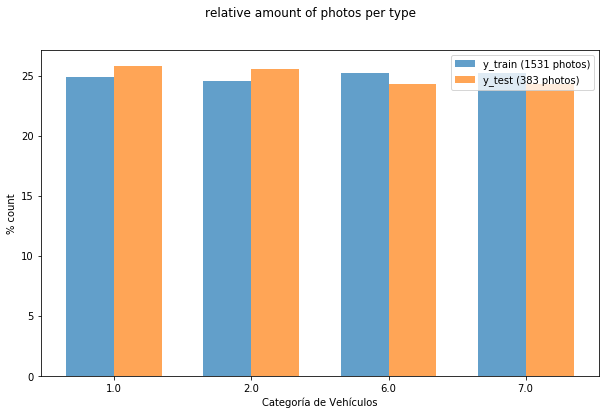

In [202]:
### Grafico que compara y_train con y_test ###
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5

    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]

    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'

    xtemp = np.arange(len(unique))
    
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique)
    plt.xlabel('Categoría de Vehículos')
    plt.ylabel(ylabel_text)

plt.figure(figsize=(10,6)) 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
legend1 = plt.legend([
    'y_train ({0} photos)'.format(len(y_train)),
    'y_test ({0} photos)'.format(len(y_test))
])
#legend2 = plt.legend([
 #   '1 = auto',
  #  '8 = moto'
#],loc=1)
#plt.gca().add_artist(legend1)
#plt.gca().add_artist(legend2)

In [ ]:
### PCA EN 2D ###

In [203]:
componentes = PCA(n_components = 2).fit_transform(X_train)

In [282]:
plt.rcParams["figure.figsize"] = [21, 18]

In [217]:
class_names = np.unique(y_test)
class_names

array([1., 2., 6., 7.])

In [286]:
labels = ['Auto', 'Camioneta', 'Furgon', 'Moto']

colors = ['rgb(0,31,63)', 'rgb(255,133,27)', 'rgb(255,65,54)', 'rgb(0,116,217)', 'rgb(133,20,75)', 'rgb(57,204,204)',
'rgb(240,18,190)', 'rgb(46,204,64)', 'rgb(1,255,112)', 'rgb(255,220,0)',
'rgb(76,114,176)', 'rgb(85,168,104)', 'rgb(129,114,178)', 'rgb(100,181,205)']

In [219]:
for k, i in enumerate(class_names):
    print(k,i)

0 1.0
1 2.0
2 6.0
3 7.0


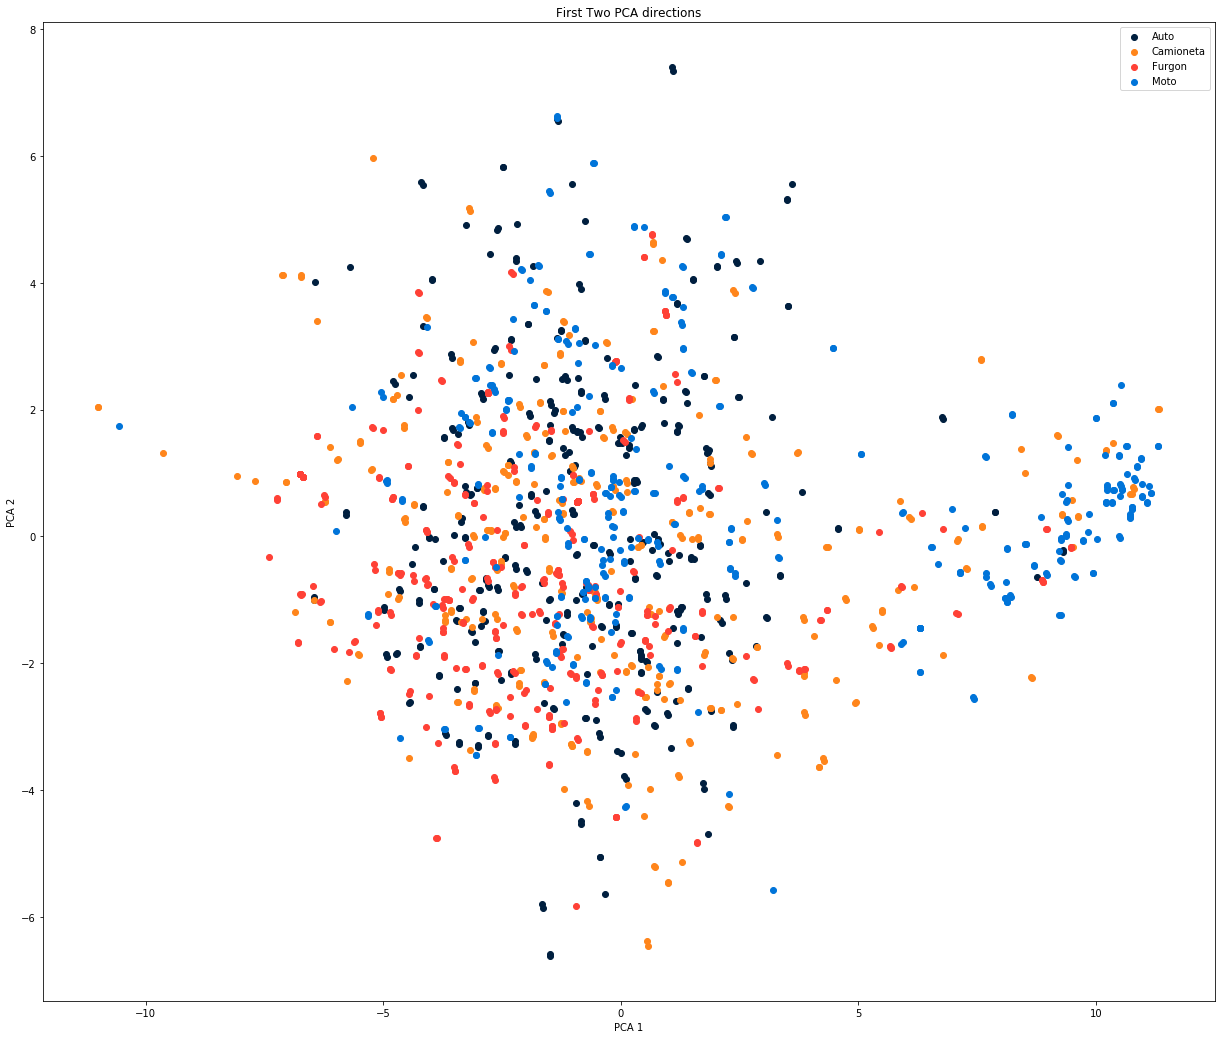

In [299]:
for k, i in enumerate(class_names):
    plt.scatter(componentes[y_train == i, 0],
               componentes[y_train == i, 1],
               color = '#%02x%02x%02x' % literal_eval(colors[k][3:]),label = labels[k])

plt.title("First Two PCA directions")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

[0.25452663 0.06948861 0.04898085]


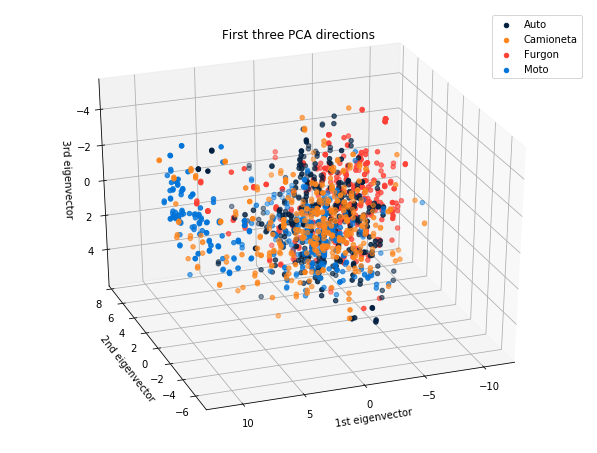

In [300]:
### PCA en 3D ###
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 6))

ax = Axes3D(fig, elev=-150, azim=110)

pca = PCA(n_components=3)

X_reduced = pca.fit_transform(X_train)

print(pca.explained_variance_ratio_)


for k, i in enumerate(class_names):
    ax.scatter(X_reduced[y_train == i, 0],
               X_reduced[y_train == i, 1],
               X_reduced[y_train == i, 2],
               color = '#%02x%02x%02x' % literal_eval(colors[k][3:]),label = labels[k])
    


ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
#ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
#ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
#ax.w_zaxis.set_ticklabels([])

plt.legend()
plt.show()





In [ ]:
### T-SNE en 2D ###

In [275]:
from sklearn.manifold import TSNE
transformada2 = TSNE(n_components=2).fit_transform(X_train)
transformada2.shape

(1531, 2)

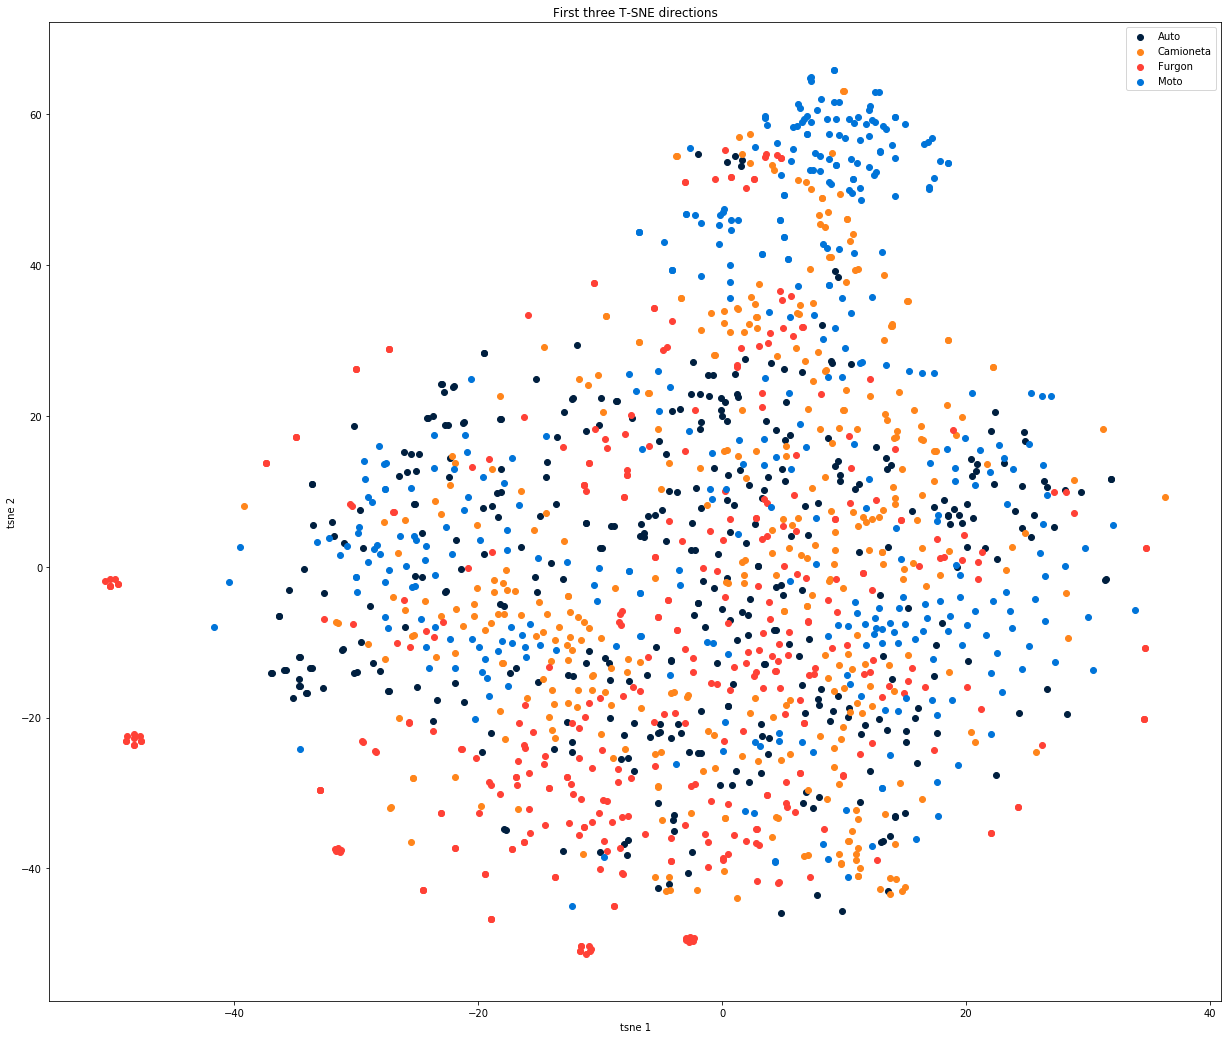

In [297]:
for k, i in enumerate(class_names):
    plt.scatter(transformada2[y_train == i, 0],
               transformada2[y_train == i, 1],
               color = '#%02x%02x%02x' % literal_eval(colors[k][3:]),label = labels[k])

plt.title("First three T-SNE directions")
plt.xlabel('tsne 1')
plt.ylabel('tsne 2')
plt.legend()
plt.show()

In [288]:
### T-SNE en 3D ###

from sklearn.manifold import TSNE
transformada3 = TSNE(n_components=3).fit_transform(X_train)
transformada3.shape

(1531, 3)

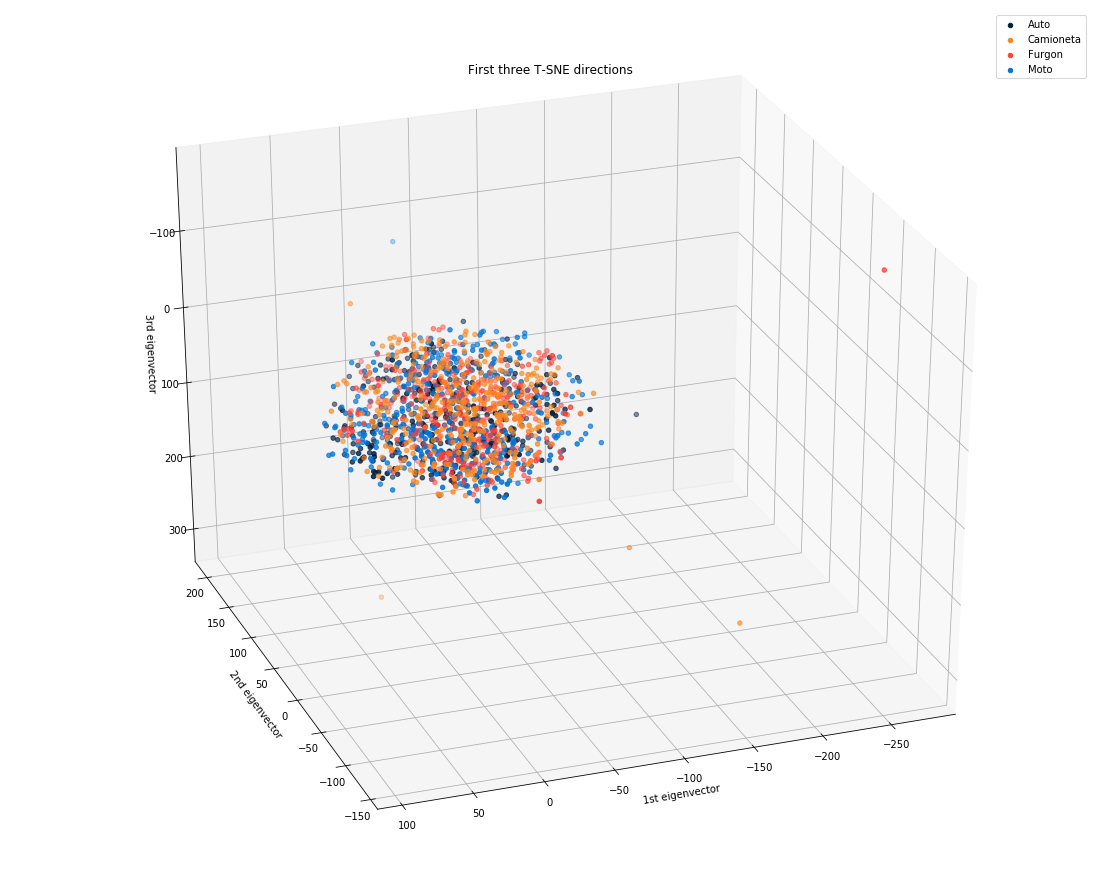

In [291]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(15, 12))

ax = Axes3D(fig, elev=-150, azim=110)

for k, i in enumerate(class_names):
    ax.scatter(transformada3[y_train == i, 0],
               transformada3[y_train == i, 1],
               transformada3[y_train == i, 2],
               color = '#%02x%02x%02x' % literal_eval(colors[k][3:]),label = labels[k])
    


ax.set_title("First three T-SNE directions")
ax.set_xlabel("1st eigenvector")
#ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
#ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
#ax.w_zaxis.set_ticklabels([])

plt.legend()
plt.show()


In [ ]:
### Modelos y sus Métricas ####

In [210]:
### Entrenamos la maquina Dummy ###
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix
import scikitplot as skplt
from timeit import default_timer as timer

comienzo = timer()

clf = DummyClassifier(strategy='prior', random_state=0)
clf.fit(X_train, y_train)

fin = timer() - comienzo

print("Tiempo Entrenamiento Dummy:",fin, " segundos")

Tiempo Entrenamiento Dummy: 0.0007383784723060671  segundos


In [211]:
### Evaluación de la máquina Dummy ###
comienzo = timer()

dummy_predict = clf.predict(X_test)

fin = timer() - comienzo

print("Tiempo Test Dummy:",fin, " segundos")



Tiempo Test Dummy: 0.00025670464492577594  segundos


In [212]:
### Metricas: F1 Score
tabla_f1_score = classification_report(y_test, dummy_predict)
print(tabla_f1_score)

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        99
         2.0       0.00      0.00      0.00        98
         6.0       0.24      1.00      0.39        93
         7.0       0.00      0.00      0.00        93

   micro avg       0.24      0.24      0.24       383
   macro avg       0.06      0.25      0.10       383
weighted avg       0.06      0.24      0.09       383



c:\users\asus\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [213]:
# Metrica: Exactitud (Acurrancy)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, dummy_predict, normalize=True, sample_weight=None)) # return the fraction of correctly classified samples (float)
print(accuracy_score(y_test, dummy_predict, normalize=False, sample_weight=None)) # Retorna cant de instancias clasificadas correctamente (int).

0.24281984334203655
93


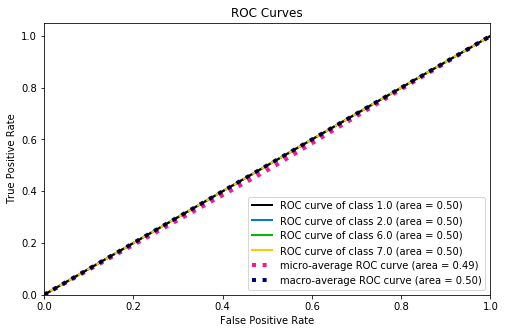

In [274]:
# Metrica: curva ROC y Métrica AUC
fig.clear()
skplt.metrics.plot_roc(y_test,clf.predict_proba(X_test))
plt.show()

Confusion matrix, without normalization


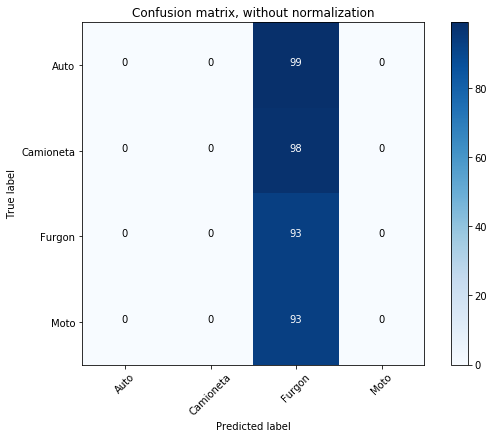

In [302]:
### Metrica: Matriz de Confusión
fig.clear()
cnf_matrix = confusion_matrix(y_test, dummy_predict)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False ,title='Confusion matrix, without normalization')

Normalized confusion matrix


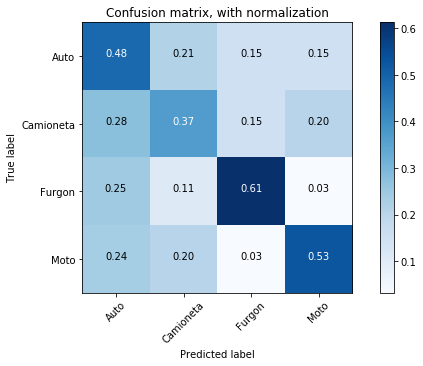

In [272]:
fig.clear()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True ,title='Confusion matrix, with normalization')

In [242]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=45)
    #plt.yticks(tick_marks, classes)
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.rcParams["figure.figsize"] = [8, 5]
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [243]:
print(labels)

['Auto', 'Camioneta', 'Furgon', 'Moto']


In [244]:
### Entrenamos la maquina SVM ###
from sklearn import svm

comienzo = timer()

svc = svm.SVC(kernel='poly', degree=2, C=1.0, probability=True, gamma='scale' )
svc.fit(X_train, y_train)  

fin = timer() - comienzo
print("Tiempo Entrenamiento SVM:",fin, " segundos")

Tiempo Entrenamiento SVM: 12.344210957620817  segundos


In [245]:
### Evaluación de la máquina SVM ###

comienzo = timer()

y_predict = svc.predict(X_test)

fin = timer() - comienzo
print("Tiempo Test SVM:",fin, " segundos")

Tiempo Test SVM: 0.49471569255365466  segundos


In [246]:
### Metricas: F1 Score
tabla_f1_score = classification_report(y_test, y_predict)
print(tabla_f1_score)

              precision    recall  f1-score   support

         1.0       0.40      0.66      0.50        99
         2.0       0.48      0.33      0.39        98
         6.0       0.70      0.60      0.65        93
         7.0       0.71      0.57      0.63        93

   micro avg       0.54      0.54      0.54       383
   macro avg       0.57      0.54      0.54       383
weighted avg       0.57      0.54      0.54       383



In [247]:
# Metrica: Exactitud (Acurrancy)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_predict, normalize=True, sample_weight=None)) # return the fraction of correctly classified samples (float)
print(accuracy_score(y_test, y_predict, normalize=False, sample_weight=None)) # Retorna cant de instancias clasificadas correctamente (int).

0.5378590078328982
206


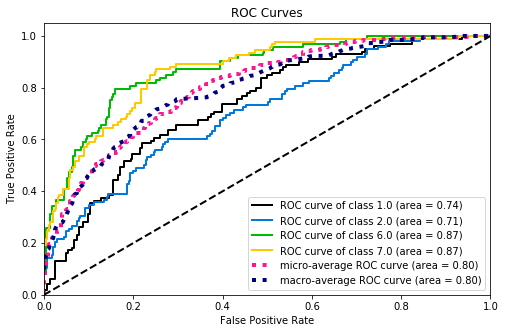

In [248]:
# Metrica: curva ROC y Métrica AUC
fig.clear()
skplt.metrics.plot_roc(y_test, svc.predict_proba(X_test))
plt.show()

Confusion matrix, without normalization


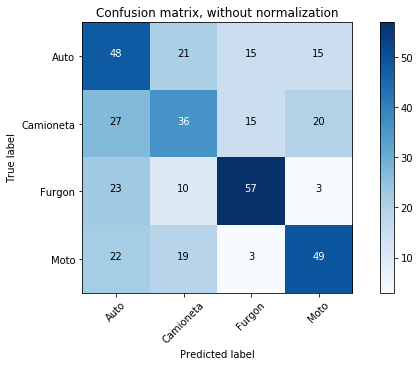

In [271]:
### Metrica: Matriz de Confusión
fig.clear()
cnf_matrix = confusion_matrix(y_test, y_predict)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False ,title='Confusion matrix, without normalization')

Normalized confusion matrix


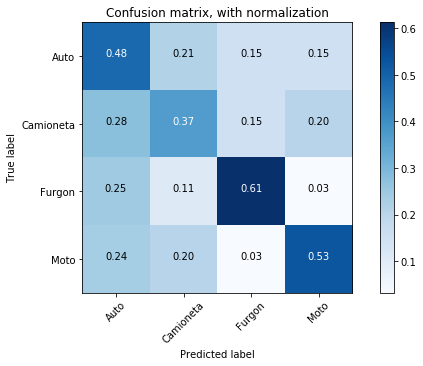

In [270]:
### Metrica: Matriz de Confusión
fig.clear()
cnf_matrix = confusion_matrix(y_test, y_predict)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True ,title='Confusion matrix, with normalization')

In [251]:
from sklearn.neighbors import KNeighborsClassifier
### KNeighborsClassifier ###
### Entrenamiento ####

comienzo = timer()
kneigh = KNeighborsClassifier(n_neighbors=6, weights='uniform')
kneigh.fit(X_train, y_train) 

fin = timer() - comienzo
print("Tiempo Entrenamiento KNeighborsClassifier:",fin, " segundos")

Tiempo Entrenamiento KNeighborsClassifier: 0.05479304245818639  segundos


In [252]:
### Evaluación de la máquina KNeighbors ###

comienzo = timer()

y_predict = kneigh.predict(X_test)

fin = timer() - comienzo
print("Tiempo Test SVM:",fin, " segundos")




Tiempo Test SVM: 0.8581121488987264  segundos


In [253]:
### Metricas: F1 Score
tabla_f1_score = classification_report(y_test, y_predict)
print(tabla_f1_score)

              precision    recall  f1-score   support

         1.0       0.41      0.63      0.50        99
         2.0       0.44      0.60      0.51        98
         6.0       0.74      0.52      0.61        93
         7.0       0.81      0.28      0.42        93

   micro avg       0.51      0.51      0.51       383
   macro avg       0.60      0.51      0.51       383
weighted avg       0.59      0.51      0.51       383



In [254]:
# Metrica: Exactitud (Acurrancy)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_predict, normalize=True, sample_weight=None)) # return the fraction of correctly classified samples (float)
print(accuracy_score(y_test, y_predict, normalize=False, sample_weight=None)) # Retorna cant de instancias clasificadas correctamente (int).

0.5091383812010444
195


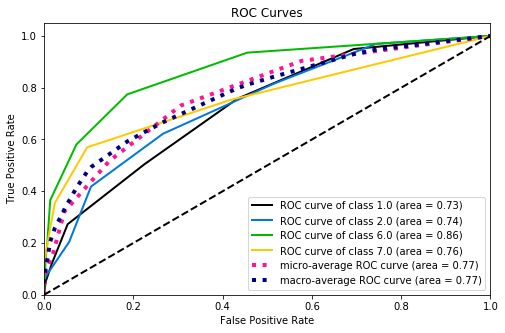

In [255]:
# Metrica: curva ROC y Métrica AUC
fig.clear()
skplt.metrics.plot_roc(y_test, kneigh.predict_proba(X_test))
plt.show()

Confusion matrix, without normalization


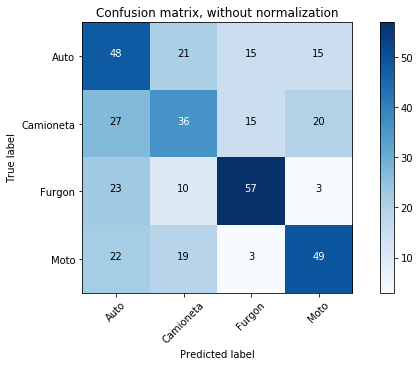

In [269]:
### Metrica: Matriz de Confusión
fig.clear()
cnf_matrix = confusion_matrix(y_test, y_predict)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False ,title='Confusion matrix, without normalization')

Normalized confusion matrix


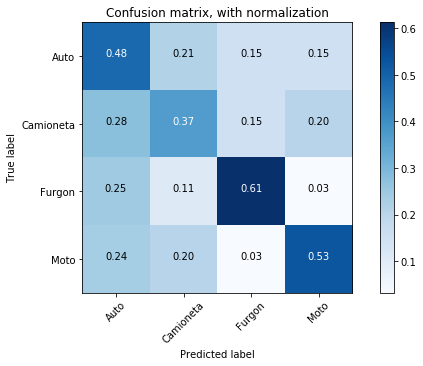

In [268]:
### Metrica: Matriz de Confusión
fig.clear()
cnf_matrix = confusion_matrix(y_test, y_predict)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True ,title='Confusion matrix, with normalization')

In [256]:
### Entrenamos la maquina RandomForest ###
from sklearn.ensemble import RandomForestClassifier

comienzo = timer()

rf = RandomForestClassifier() # Creando el modelo
rf.fit(X_train, y_train) # Ajustando el modelo

fin = timer() - comienzo
print("Tiempo Entrenamiento RandomForest:",fin, " segundos")

c:\users\asus\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Tiempo Entrenamiento RandomForest: 0.2514340903762786  segundos


In [257]:
### Evaluamos RandomForest ###

comienzo = timer()

y_predict = rf.predict(X_test)

fin = timer() - comienzo
print("Tiempo Test RandomForest:",fin, " segundos")

Tiempo Test RandomForest: 0.0050833161712944275  segundos


In [258]:
### Metricas: F1 Score
tabla_f1_score = classification_report(y_test, y_predict)
print(tabla_f1_score)

              precision    recall  f1-score   support

         1.0       0.40      0.48      0.44        99
         2.0       0.42      0.37      0.39        98
         6.0       0.63      0.61      0.62        93
         7.0       0.56      0.53      0.54        93

   micro avg       0.50      0.50      0.50       383
   macro avg       0.50      0.50      0.50       383
weighted avg       0.50      0.50      0.50       383



In [259]:
# Metrica: Exactitud (Acurrancy)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_predict, normalize=True, sample_weight=None)) # return the fraction of correctly classified samples (float)
print(accuracy_score(y_test, y_predict, normalize=False, sample_weight=None)) # Retorna cant de instancias clasificadas correctamente (int).

0.4960835509138381
190


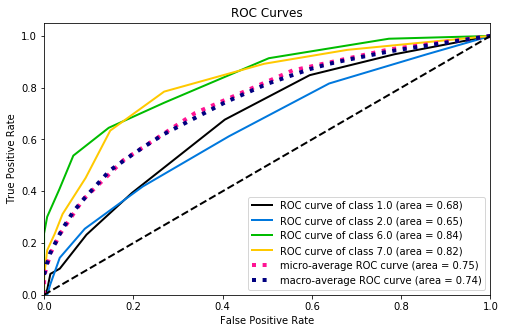

In [260]:
# Metrica: curva ROC y Métrica AUC
fig.clear()
skplt.metrics.plot_roc(y_test, rf.predict_proba(X_test))
plt.show()

Confusion matrix, without normalization


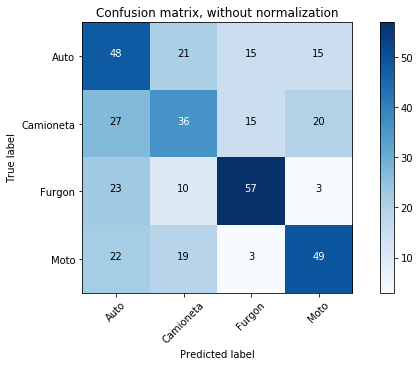

In [266]:
### Metrica: Matriz de Confusión
fig.clear()
cnf_matrix = confusion_matrix(y_test, y_predict)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False ,title='Confusion matrix, without normalization')

Normalized confusion matrix


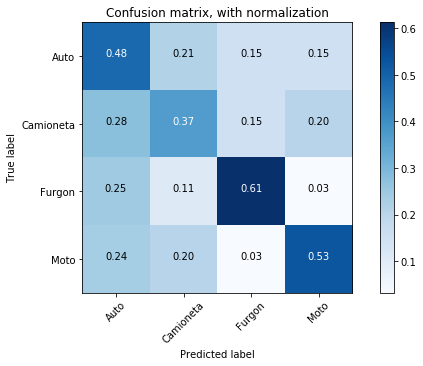

In [267]:
### Metrica: Matriz de Confusión
fig.clear()
cnf_matrix = confusion_matrix(y_test, y_predict)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True ,title='Confusion matrix, with normalization')

In [265]:
### Predecir categoria ####
img = cv2.imread('imagenes/camioneta.jpg')
resize_img=cv2.resize(img, (28,28))
resize_img = cv2.cvtColor(resize_img,cv2.COLOR_BGR2GRAY) 
                    
# Normalización DE PIXELES, DIVIDO CADA PIXEL POR 255,
resize_img = resize_img / 255 
array_img = resize_img.ravel()
#array_img = np.insert(array_img,len(array_img), 6)

Xnew = []
Xnew.append(array_img)

### Vemos a que clase pertenece ###
print(clf.predict(Xnew)) # dummy
print(svc.predict(Xnew)) # svm
print(kneigh.predict(Xnew)) # K-neighbors
print(rf.predict(Xnew)) # RandomForest


[6.]
[2.]
[2.]
[2.]


In [ ]:
FALTA HACER LA APP WEB...............

In [ ]:
FALTA COMPLETAR EL INFORME..............